# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Loading Libraries

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_validate
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [6]:
#Loading the dataset that we cleaned in TSNE project
df = pd.read_csv(r'C:\Users\nihar\affrd_cleaned_preprocessed.csv')

In [7]:
df['Score'].value_counts() #counting the number of positive and negative datapoints

positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
positive_points = df[df['Score'] == 'positive'].sample(n=20000, random_state=0)#randomly sampling 20k positive points
negative_points = df[df['Score'] == 'negative'].sample(n=20000, random_state=0)# randomly sampling 20k negative points
total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
                                       axis = 0,    #- ascending order so that we can do time based splitting later.
                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
                                    kind = 'quicksort',
                                     na_position = 'last')
sorted_data['Score'].value_counts()
sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [11]:
sorted_data.shape

(40000, 13)

In [12]:
#storing my 'cleaned text' column in d_train into datapoint matrix x_train and 'Score' column in d_train into y_train-
#- and similar thing we are doing for, d_cv and d_test
d_train = sorted_data.iloc[0:20000] #taking top 60k data points from sorted_data and storing it in d_train
d_cv = sorted_data.iloc[20000:30000]#taking next 20k data points from sorted_data and storing it in d_cv
d_test = sorted_data.iloc[30000:40000]#taking last 20k data points from sorted_data and storing it in d_test

In [13]:
#Storing 'CleanedText' and 'Score' columns in d_train into x_train and y_train respectively and doing the same for d_cv and-
#-d_test
x_train = d_train['CleanedText']
x_cv = d_cv['CleanedText']
x_test = d_test['CleanedText']
y_train = d_train['Score']
y_cv = d_cv['Score']
y_test = d_test['Score']

In [14]:
#changing 'negative' to 0 and 'positive' to 1 in y_train and binarizing the elements in y_train such that now-
#- 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_train:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_train = a
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [15]:
#changing 'negative' to 0 and 'positive' to 1 in y_cv and binarizing the elements in y_cv such that now-
#- 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_cv:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_cv = a
lb.fit(y_cv)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [16]:
#changing 'negative' to 0 and 'positive' to 1 in y_test and binarizing the elements in y_test such that now-
#- 1 will represent positive points and 0 will represent negative points
list_1 = []
for i in y_test:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_test = a
lb.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [17]:
y_train.shape

(20000, 1)

In [18]:
y_train= np.ravel(y_train)
y_cv= np.ravel(y_cv)
y_test= np.ravel(y_test)

In [19]:
y_train.shape

(20000,)

# 2. Bag of words (BOW)

In [34]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 50) #defining our BOW model here. Here we are considering words which occur more than-
#-50 times in our document.
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'alway': 44, 'enjoy': 471, 'movi': 932, 'funni': 592, 'didnt': 397, 'hesit': 690, 'pick': 1049, 'guess': 651, 'market': 875, 'plan': 1059, 'make': 864, 'famili': 513, 'someth': 1327, 'strong': 1394, 'usual': 1558, 'version': 1569, 'warn': 1586, 'want': 1583, 'avoid': 89, 'bring': 176, 'often': 980, 'come': 280, 'like': 821, 'find': 538, 'one': 987, 'snack': 1315, 'popcorn': 1075, 'favorit': 524, 'part': 1024, 'room': 1206, 'classic': 264, 'moment': 923, 'miss': 914, 'couldnt': 319, 'stop': 1385, 'great': 637, 'keep': 771, 'cant': 210, 'watch': 1590, 'time': 1487, 'ever': 482, 'made': 858, 'mix': 916, 'strang': 1390, 'stori': 1388, 'along': 38, 'thing': 1472, 'world': 1630, 'live': 834, 'dead': 364, 'recent': 1156, 'wait': 1578, 'hous': 710, 'year': 1645, 'peopl': 1038, 'tri': 1526, 'break': 169, 'cover': 326, 'take': 1438, 'place': 1057, 'excel': 490, 'job': 765, 'see': 1247, 'use': 1557, 'machin': 857, 'purchas': 1124, 'amazon': 46, 'produc': 1109, 'delici': 376, 'latt': 798, 'pod': 

In [35]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [36]:
#here we are creating a dataframe out of train_bow,cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [37]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float

In [38]:
standardized_train.shape

(20000, 1661)

## [2.1] Decision Trees on BOW

In [39]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
min_samples_split_train = []
max_depth_train = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50] #min_samples_split=min no of samples that an internal node should have so that we can split it
#For instance, if min_samples_split = 5, and there are 7 samples at an internal node, 
#then the split is allowed. But let's say the split results in two leaves, 
#one with 1 sample, and another with 6 samples. If min_samples_leaf = 2, 
#then the split won't be allowed (even if the internal node has 7 samples) because one of the leaves resulted
#will have less then the minimum number of samples required to be at a leaf node.
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_train.append(j)
        max_depth_train.append(i)

In [40]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
min_samples_split_cv = []
max_depth_cv = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_cv.append(j)
        max_depth_cv.append(i)

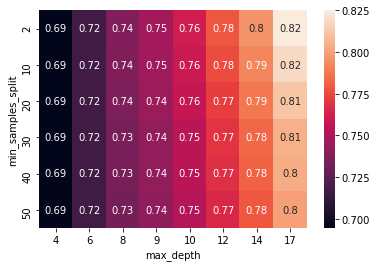

In [41]:
train_df = pd.DataFrame()
train_df['min_samples_split'] = min_samples_split_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("min_samples_split", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

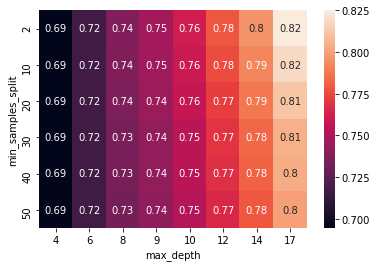

In [43]:
cv_df = pd.DataFrame()
cv_df['min_samples_split'] = min_samples_split_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("min_samples_split", "max_depth", "cv_roc")
ax = sns.heatmap(train_df, annot=True)

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.01, therefore we will choose that value of C as our hyperparameter value.</pre>

In [22]:
dt = DecisionTreeClassifier(max_depth = 50,min_samples_split=60)
dt.fit(standardized_train,y_train)
pred = dt.predict(standardized_test)
print('\nFor max_depth = {0} and min_samples_split = {1}, the area under AUC curve is = {2}'.format(50,60,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.8656845797683996



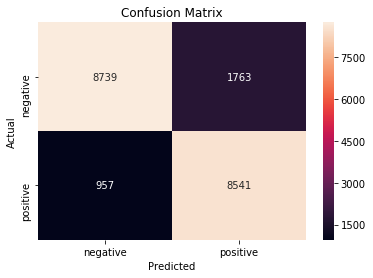

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 89.92419456727733, TNR = 83.21272138640259, FPR = 16.787278613597408, FNR = 10.075805432722678


In [23]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,60,TPR,TNR,FPR,FNR))

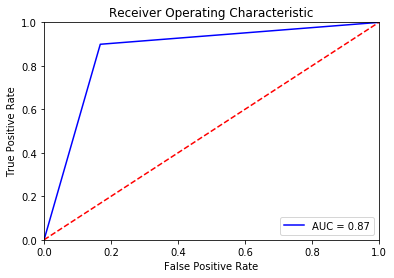

In [24]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Printing top 20 features
imp = dt.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

In [ ]:
##Graphviz

## 3. TFIDF

In [32]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 50)#defining our tf-idf model and considering only those words which occur more than 10-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'alway': 44, 'enjoy': 471, 'movi': 932, 'funni': 592, 'didnt': 397, 'hesit': 690, 'pick': 1049, 'guess': 651, 'market': 875, 'plan': 1059, 'make': 864, 'famili': 513, 'someth': 1327, 'strong': 1394, 'usual': 1558, 'version': 1569, 'warn': 1586, 'want': 1583, 'avoid': 89, 'bring': 176, 'often': 980, 'come': 280, 'like': 821, 'find': 538, 'one': 987, 'snack': 1315, 'popcorn': 1075, 'favorit': 524, 'part': 1024, 'room': 1206, 'classic': 264, 'moment': 923, 'miss': 914, 'couldnt': 319, 'stop': 1385, 'great': 637, 'keep': 771, 'cant': 210, 'watch': 1590, 'time': 1487, 'ever': 482, 'made': 858, 'mix': 916, 'strang': 1390, 'stori': 1388, 'along': 38, 'thing': 1472, 'world': 1630, 'live': 834, 'dead': 364, 'recent': 1156, 'wait': 1578, 'hous': 710, 'year': 1645, 'peopl': 1038, 'tri': 1526, 'break': 169, 'cover': 326, 'take': 1438, 'place': 1057, 'excel': 490, 'job': 765, 'see': 1247, 'use': 1557, 'machin': 857, 'purchas': 1124, 'amazon': 46, 'produc': 1109, 'delici': 376, 'latt': 798, 'pod': 

In [ ]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_cv into matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [ ]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [ ]:
standardized_train = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test = StandardScaler().fit_transform(test_tfidf_df)

### 3.1 Decision Tree on TFIDF

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
min_samples_split_train = []
max_depth_train = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_train.append(j)
        max_depth_train.append(i)

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
cv_roc = []
min_samples_split_cv = []
max_depth_cv = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_cv.append(j)
        max_depth_cv.append(i)

In [ ]:
train_df = pd.DataFrame()
train_df['min_samples_split'] = min_samples_split_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("min_samples_split", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

In [ ]:
cv_df = pd.DataFrame()
cv_df['min_samples_split'] = min_samples_split_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("min_samples_split", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

In [ ]:
dt = RandomForestClassifier(max_depth = 100,min_samples_split=60)
dt.fit(standardized_train,y_train)
pred = dt.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(100,60,roc_auc_score(y_test, pred)))

In [ ]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(100,60,TPR,TNR,FPR,FNR))

In [ ]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Printing top 20 features
imp = rfc.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

In [33]:
##Graphviz

## 4. Word2Vec

In [ ]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [ ]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [ ]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [ ]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

## 4.1 Average Word2Vec

In [ ]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

In [ ]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

In [ ]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
avg_w2v_tr = pd.DataFrame(sent_vectors)
avg_w2v_cv = pd.DataFrame(sent_vectors_cv)
avg_w2v_te = pd.DataFrame(sent_vectors_test)

In [ ]:
standardized_train = StandardScaler().fit_transform(avg_w2v_tr)
standardized_cv = StandardScaler().fit_transform(avg_w2v_cv)
standardized_test = StandardScaler().fit_transform(avg_w2v_te)

### 4.1.1 Random Forest on Avg W2V

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
min_samples_split_train = []
max_depth_train = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_train.append(j)
        max_depth_train.append(i)

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
cv_roc = []
min_samples_split_cv = []
max_depth_cv = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_cv.append(j)
        max_depth_cv.append(i)

In [ ]:
train_df = pd.DataFrame()
train_df['min_samples_split'] = min_samples_split_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("min_samples_split", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

In [ ]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = min_samples_split_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("min_samples_split", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

In [ ]:
rfc = RandomForestClassifier(max_depth = 50,n_estimators=30)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(50,30,roc_auc_score(y_test, pred)))

In [ ]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,30,TPR,TNR,FPR,FNR))

In [ ]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.2 Weighted W2V

In [ ]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model and considering only those words which occur more than 50-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

In [ ]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [ ]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

In [ ]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

In [ ]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

In [ ]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [ ]:
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

### 4.2.1 Decision Trees on Weighted W2V

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
min_samples_split_train = []
max_depth_train = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_train.append(j)
        max_depth_train.append(i)

In [ ]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
cv_roc = []
min_samples_split_cv = []
max_depth_cv = []
max_depth = [4,6,8,9,10,12,14,17]
min_samples_split=[2,10,20,30,40,50]
for i in max_depth:
    for j in min_samples_split: 
        dt = DecisionTreeClassifier(max_depth = i,min_samples_split=j)
        dt.fit(standardized_train,y_train)
        pred = dt.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))#roc_auc_score calculates area under the roc curve 
        min_samples_split_cv.append(j)
        max_depth_cv.append(i)

In [ ]:
train_df = pd.DataFrame()
train_df['min_samples_split'] = min_samples_split_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("min_samples_split", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

In [ ]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = min_samples_split_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("min_samples_split", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

In [ ]:
rfc = RandomForestClassifier(max_depth = 50,n_estimators=30)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(50,30,roc_auc_score(y_test, pred)))

In [ ]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,30,TPR,TNR,FPR,FNR))

In [ ]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [5] Conclusions

In [114]:
list_1 = [['BOW','L1',0.01, 0.8657797997265029, 89.92419456727733,83.23176537802324,16.768234621976767,10.075805432722678],
         ['BOW','L2',0.0001,0.8633505779905593,90.61907770056854,82.05103789754332,17.948962102456676, 9.38092229943146],
         ['TFIDF','L1',0.01,0.8712936047356781,89.2082543693409,85.05046657779471,14.949533422205294,10.791745630659086],
         ['TFIDF','L2',0.001,0.8673992508080061,89.02926931985681,84.45058084174443,15.54941915825557,10.970730680143188],
         ['Average W2V','L1',0.1,0.8326658312012605,86.18656559275637,80.34660064749572,19.653399352504287,13.81343440724363],
         ['Average W2V','L2',0.01,0.8323751386443894,86.17603706043377,80.2989906684441,19.701009331555895,13.823962939566226],
         ['Weighted W2V','L1',0.01,0.8005339475692325,83.60707517372077,76.49971434012569,23.500285659874308,16.392924826279216],
         ['Weighted W2V','L2',0.01,0.7995314211625865,83.50178985049484,76.40449438202246,23.595505617977526,16.49821014950516]]
columns= ['Vectorizer', 'Regualrizer', 'Hyperparameter','AUC', 'TPR','TNR','FPR','FNR' ]
pd.DataFrame(list_1,columns = columns)

,Vectorizer,Regualrizer,Hyperparameter,AUC,TPR,TNR,FPR,FNR
0,BOW,L1,0.0100,0.865780,89.924195,83.231765,16.768235,10.075805
1,BOW,L2,0.0001,0.863351,90.619078,82.051038,17.948962,9.380922
2,TFIDF,L1,0.0100,0.871294,89.208254,85.050467,14.949533,10.791746
3,TFIDF,L2,0.0010,0.867399,89.029269,84.450581,15.549419,10.970731
4,Average W2V,L1,0.1000,0.832666,86.186566,80.346601,19.653399,13.813434
5,Average W2V,L2,0.0100,0.832375,86.176037,80.298991,19.701009,13.823963
6,Weighted W2V,L1,0.0100,0.800534,83.607075,76.499714,23.500286,16.392925
7,Weighted W2V,L2,0.0100,0.799531,83.501790,76.404494,23.595506,16.498210


<pre>1. We can see from above table that Logistic Regression with L1 regularizer performs best on TFIDF vector representation of our reviews in determining whether a review is positive or not.</pre>
<pre>2. Logistic Regression + L1 regularizer + TFIDF vector representation also gives us the least biased model.</pre>
<pre>3. On the basis of AUC score, our models from best to worst are as follows:
<b>Logistic Regression + L1 regularizer + TFIDF > Logistic Regression + L2 regularizer + TFIDF > Logistic Regression + L1 regularizer + BOW > Logistic Regression + L2 regularizer + BOW > Logistic Regression + L1 regularizer + Avg W2V > Logistic Regression + L2 regularizer + Avg W2V > Logistic Regression + L1 regularizer + Weighted W2V > Logistic Regression + L2 regularizer + Weighted W2V</b></pre>